In [1]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/Gold%20and%20Silver%20Prices%20Dataset/silver_price.csv")
data.head()

,date,price
0,1968-01-02,2.173
1,1968-01-03,2.225
2,1968-01-04,2.171
3,1968-01-05,2.157
4,1968-01-08,2.163


In [2]:
from sklearn.preprocessing import StandardScaler
new_data = data.copy()
scaled_feature = new_data[['price']]
scaler = StandardScaler().fit(scaled_feature.values)
scaled_feature = scaler.transform(scaled_feature.values)
new_data[['price']] = scaled_feature
new_data = new_data.dropna()
new_data

,date,price
0,1968-01-02,-0.948810
1,1968-01-03,-0.942149
2,1968-01-04,-0.949067
3,1968-01-05,-0.950860
4,1968-01-08,-0.950092
...,...,...
13470,2021-03-30,1.891038
13471,2021-03-31,1.847480
13472,2021-04-01,1.887836
13473,2021-04-06,1.980716


Text(0.5, 1.0, 'Silver Price')

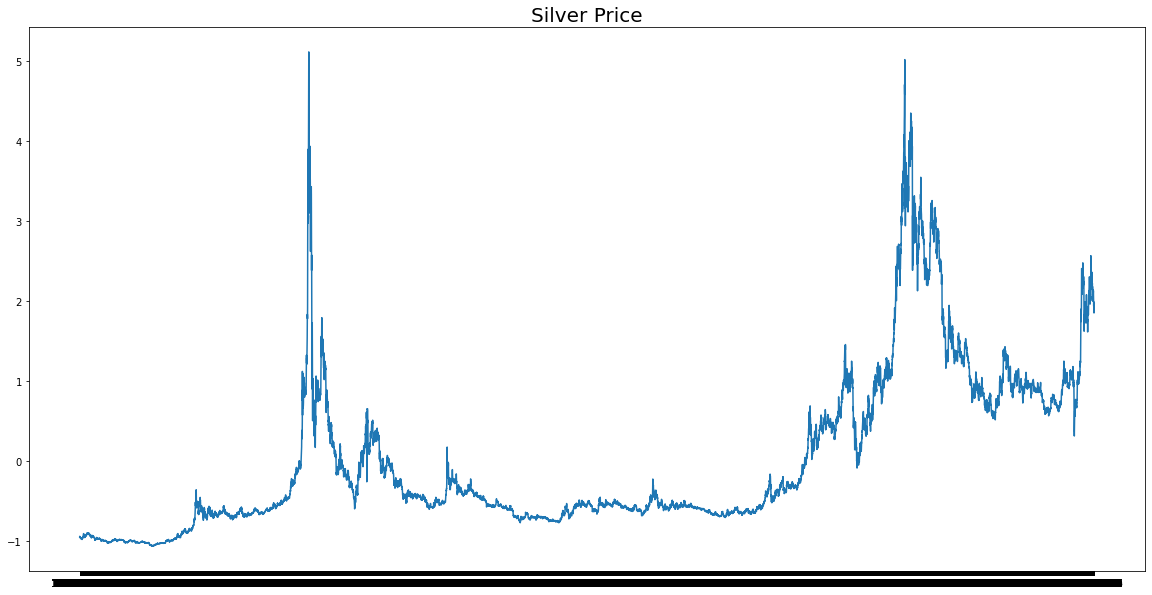

In [3]:
import matplotlib.pyplot as plt

dates = new_data['date'].to_numpy()
price  = new_data['price'].to_numpy()
 
plt.figure(figsize=(20,10))
plt.plot(dates, price)
plt.title('Silver Price', fontsize=20)

In [4]:
from sklearn.model_selection import train_test_split

dates_train, dates_test, price_train, price_test = train_test_split(dates, price, test_size = 0.2, random_state = 0, shuffle = False)
import tensorflow as tf
from tensorflow.data import Dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(price_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(price_test, window_size=60, batch_size=100, shuffle_buffer=1000)

2022-03-05 00:42:37.780659: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
                    LSTM(60, return_sequences=True),
                    LSTM(60),
                    Dense(30, activation='relu'),
                    Dense(30, activation='relu'),
                    Dense(1)])
from tensorflow import optimizers
from keras.losses import Huber

model.compile(loss=Huber(),
              optimizer=optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9),
              metrics=['mae'])
from keras.callbacks import Callback

data_scale = (price.max() - price.min())
print(f'Data Scale: {data_scale*0.1}')

class StopTraining(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < (data_scale*0.1) and logs.get('val_mae') < (data_scale*0.1)):
            self.model.stop_training = True

custom_callback = StopTraining()

Data Scale: 0.6172158295883432


In [6]:
history = model.fit(train_set,
                    validation_data= test_set,
                    epochs=10,
                    callbacks=[custom_callback],
                    verbose=2)

Epoch 1/10


2022-03-05 00:42:39.336703: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


108/108 - 22s - loss: 0.1906 - mae: 0.5489 - val_loss: 1.0270 - val_mae: 1.5173
Epoch 2/10
108/108 - 16s - loss: 0.1553 - mae: 0.4806 - val_loss: 1.0382 - val_mae: 1.5301
Epoch 3/10
108/108 - 16s - loss: 0.1322 - mae: 0.4289 - val_loss: 1.0341 - val_mae: 1.5262
Epoch 4/10
108/108 - 17s - loss: 0.1158 - mae: 0.3884 - val_loss: 1.0179 - val_mae: 1.5093
Epoch 5/10
108/108 - 16s - loss: 0.1035 - mae: 0.3554 - val_loss: 0.9987 - val_mae: 1.4888
Epoch 6/10
108/108 - 17s - loss: 0.0936 - mae: 0.3282 - val_loss: 0.9761 - val_mae: 1.4646
Epoch 7/10
108/108 - 16s - loss: 0.0855 - mae: 0.3043 - val_loss: 0.9528 - val_mae: 1.4393
Epoch 8/10
108/108 - 16s - loss: 0.0782 - mae: 0.2829 - val_loss: 0.9260 - val_mae: 1.4099
Epoch 9/10
108/108 - 17s - loss: 0.0719 - mae: 0.2634 - val_loss: 0.8986 - val_mae: 1.3794
Epoch 10/10
108/108 - 17s - loss: 0.0660 - mae: 0.2454 - val_loss: 0.8695 - val_mae: 1.3465


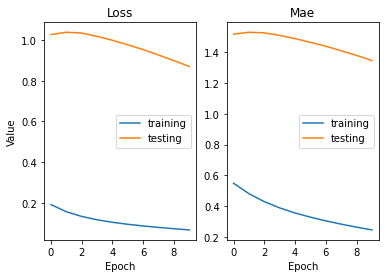

In [7]:
import matplotlib.pyplot as plt

plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.subplot(122)
plt.title('Mae')
plt.plot(history.history['mae'], label='training')
plt.plot(history.history['val_mae'], label='testing')
plt.xlabel('Epoch')
plt.legend()
plt.show()